# Neuro-Stable Diffusion 🧠

In [1]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms
import accelerate
import scipy

import pandas as pd

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
# torch_device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = "mps" # M1

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

### Modifying the forward method of the UNet

In [5]:
from fastcore.basics import *
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from typing import Tuple, Union
import time

@patch
def forward(
        self:UNet2DConditionModel,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        return_dict: bool = True,
    ) -> Union[UNet2DConditionOutput, Tuple]:
        r"""
        Args:
            sample (`torch.FloatTensor`): (batch, channel, height, width) noisy inputs tensor
            timestep (`torch.FloatTensor` or `float` or `int`): (batch) timesteps
            encoder_hidden_states (`torch.FloatTensor`): (batch, channel, height, width) encoder hidden states
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`models.unet_2d_condition.UNet2DConditionOutput`] instead of a plain tuple.
        Returns:
            [`~models.unet_2d_condition.UNet2DConditionOutput`] or `tuple`:
            [`~models.unet_2d_condition.UNet2DConditionOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.
        """
        # By default samples have to be AT least a multiple of the overall upsampling factor.
        # The overall upsampling factor is equal to 2 ** (# num of upsampling layears).
        # However, the upsampling interpolation output size can be forced to fit any upsampling size
        # on the fly if necessary.
        default_overall_up_factor = 2**self.num_upsamplers

        # upsample size should be forwarded when sample is not a multiple of `default_overall_up_factor`
        forward_upsample_size = False
        upsample_size = None

        if any(s % default_overall_up_factor != 0 for s in sample.shape[-2:]):
            logger.info("Forward upsample size to force interpolation output size.")
            forward_upsample_size = True

        # 0. center input if necessary
        if self.config.center_input_sample:
            sample = 2 * sample - 1.0

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].type(torch.FloatTensor).to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        t_emb = self.time_proj(timesteps)

        # timesteps does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=self.dtype)
        emb = self.time_embedding(t_emb)

        # 2. pre-process
        sample = self.conv_in(sample)

        # 3. down
        down_block_res_samples = (sample,)
        
        # THIS IS WHAT WE WANT TO MODIFY
        sample_list = []
        res_samples_list = []
        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "attentions") and downsample_block.attentions is not None:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb)
            sample_list.append(sample)
            res_samples_list.append(res_samples)

            down_block_res_samples += res_samples

        # 4. mid
        sample = self.mid_block(sample, emb, encoder_hidden_states=encoder_hidden_states)

        # 5. up
        for i, upsample_block in enumerate(self.up_blocks):
            is_final_block = i == len(self.up_blocks) - 1

            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

            # if we have not reached the final block and need to forward the
            # upsample size, we do it here
            if not is_final_block and forward_upsample_size:
                upsample_size = down_block_res_samples[-1].shape[2:]

            if hasattr(upsample_block, "attentions") and upsample_block.attentions is not None:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    upsample_size=upsample_size,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample, temb=emb, res_hidden_states_tuple=res_samples, upsample_size=upsample_size
                )
        # 6. post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        if not return_dict:
            return (sample,)

        return sample_list, UNet2DConditionOutput(sample=sample)

## Investigating the diffusion loop

Setting `num_inference_steps`, we see the UNet's `forward` method gets called 4 times.

0it [00:00, ?it/s]

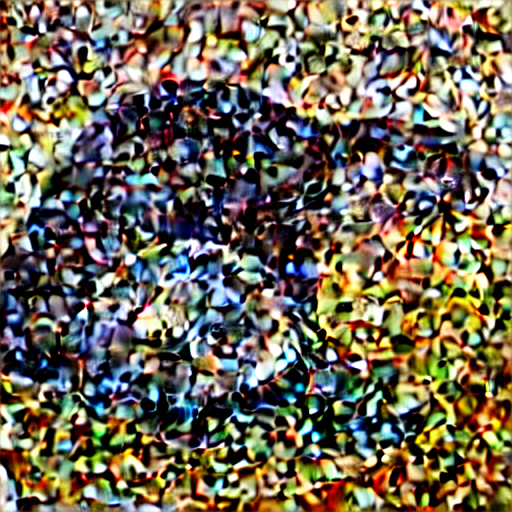

In [6]:
# Some settings
prompt = ["A watercolor painting of an otter"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 20           # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# if multiple inference steps
sample_list_list = []

# Loop
with autocast("cpu"): # previosuly cuda
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            sample_list, _ = unet(latent_model_input, t, encoder_hidden_states=text_embeddings) # this is just so we get the sample_list
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)[1].sample # added the [1] because now we're returning a tuple
            sample_list_list.append(sample_list)
            
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if i == 10:break

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

### Investigating the UNet samples

In [7]:
len(sample_list)

4

In [8]:
print(sample_list[0].shape)
print(sample_list[1].shape)
print(sample_list[2].shape)
print(sample_list[3].shape)

torch.Size([2, 320, 32, 32])
torch.Size([2, 640, 16, 16])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])


In [20]:
# for multiple inference steps, the sample_list_list
print(f"Length of sample list list: {len(sample_list_list)}")

Length of sample list list: 11


In [11]:
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('attention_head_dim', 8),
            ('_class_name', 'UNet2DConditionModel'),
            ('_diffusers_ve

In [12]:
c, uc = sample_list[0]
d = c - uc
d.shape

torch.Size([320, 32, 32])

In [13]:
d_mean = d.mean(dim=0)
d_mean.shape

torch.Size([32, 32])

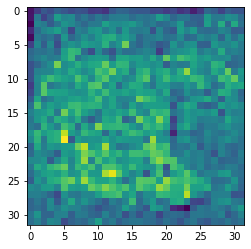

In [14]:
plt.imshow(d_mean.detach().cpu())

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


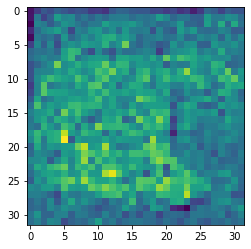

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


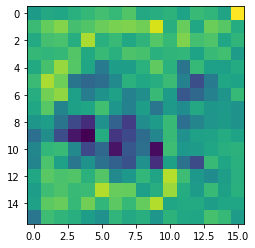

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


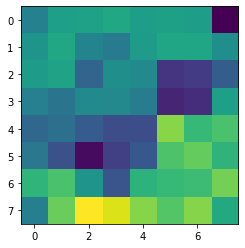

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


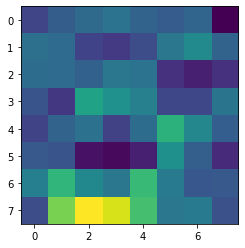

In [18]:
for i in range(len(sample_list)):
    print(f"Level in downsampling hierarchy: {i}")
    c, uc = sample_list[i]
    d = c - uc
    print(f"Shape of difference between conditional and unconditional preds: {d.shape}")
    d_mean = d.mean(dim=0)
    print(f"Shape of mean of difference: {d_mean.shape}")
    plt.imshow(d_mean.detach().cpu())
    plt.show()

For reusability let's put the loop above to a function

In [21]:
def show_sample_reps(sample_list):
    for i in range(len(sample_list)):
        print(f"Level in downsampling hierarchy: {i}")
        c, uc = sample_list[i]
        d = c - uc
        print(f"Shape of difference between conditional and unconditional preds: {d.shape}")
        d_mean = d.mean(dim=0)
        print(f"Shape of mean of difference: {d_mean.shape}")
        plt.imshow(d_mean.detach().cpu())
        plt.show()

## Looking at the samples in the full list from all inference steps

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


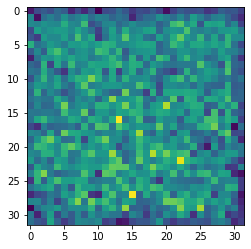

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


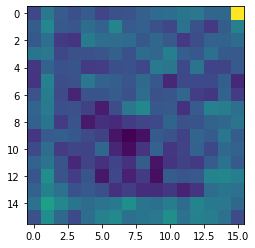

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


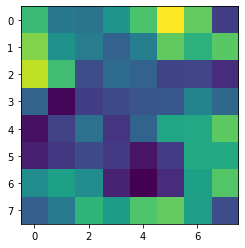

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


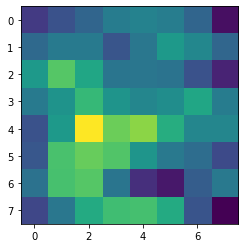

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


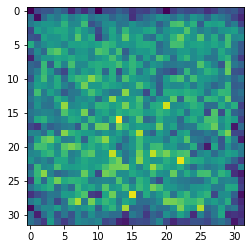

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


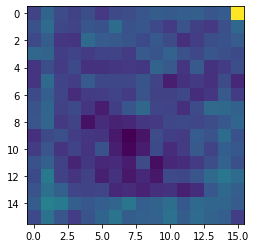

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


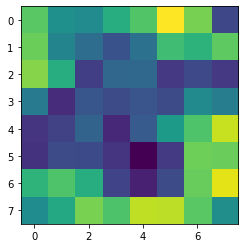

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


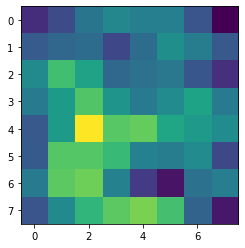

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


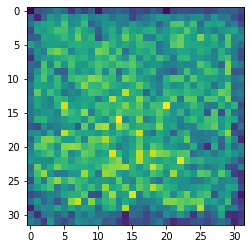

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


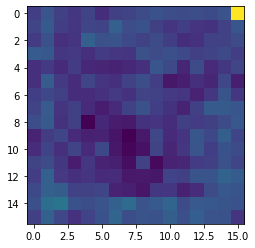

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


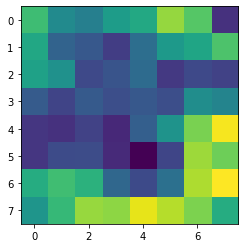

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


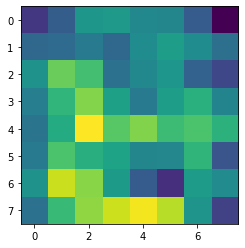

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


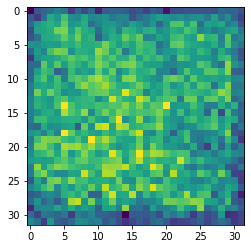

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


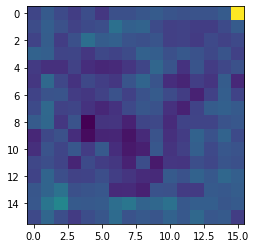

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


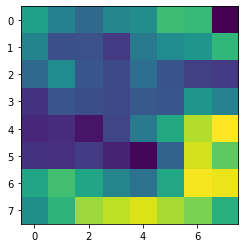

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


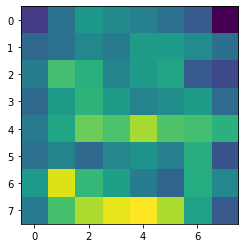

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


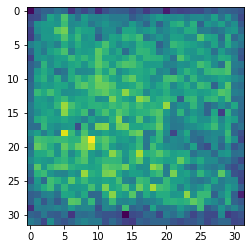

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


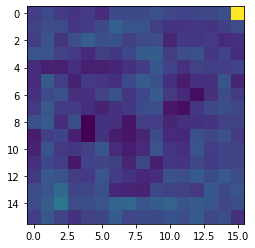

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


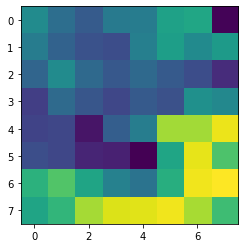

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


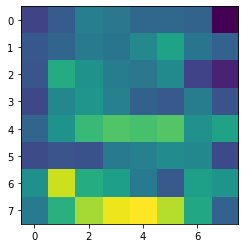

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


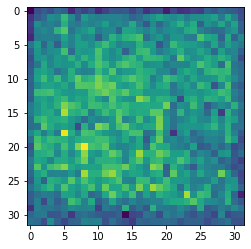

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


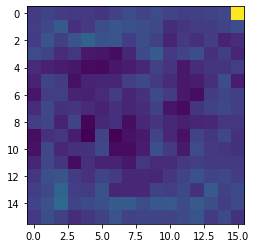

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


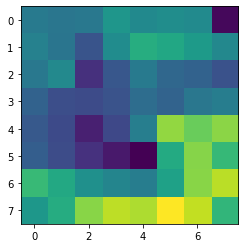

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


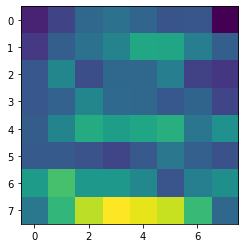

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


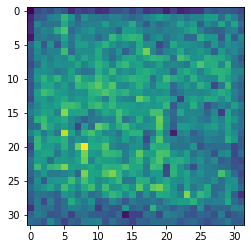

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


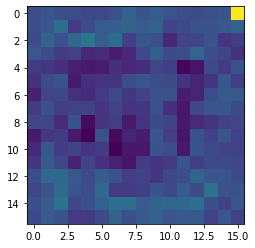

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


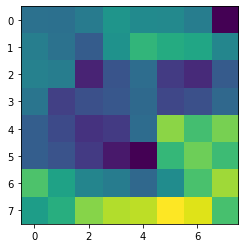

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


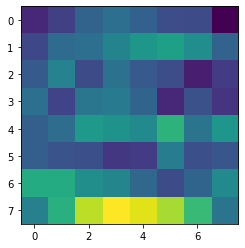

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


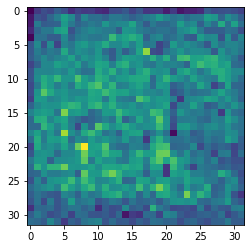

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


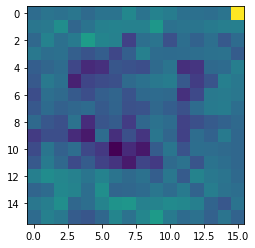

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


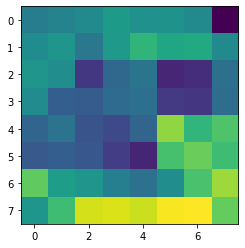

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


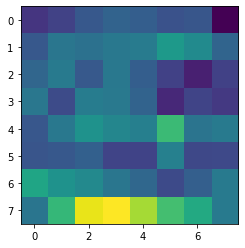

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


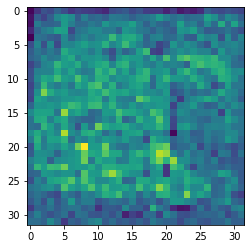

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


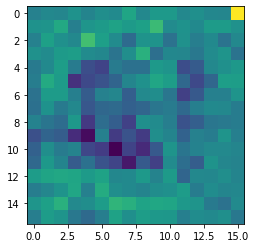

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


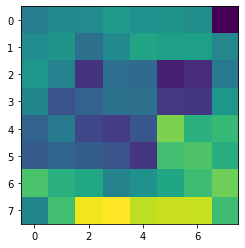

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


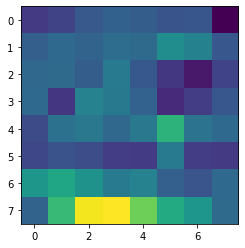

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


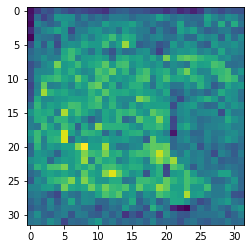

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


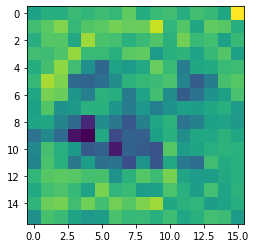

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


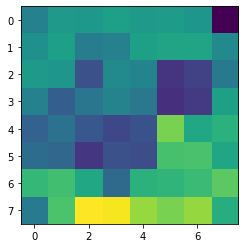

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


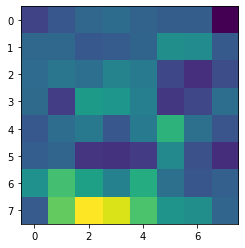

Level in downsampling hierarchy: 0
Shape of difference between conditional and unconditional preds: torch.Size([320, 32, 32])
Shape of mean of difference: torch.Size([32, 32])


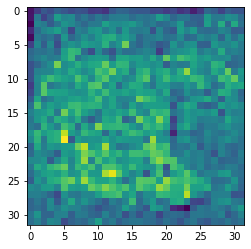

Level in downsampling hierarchy: 1
Shape of difference between conditional and unconditional preds: torch.Size([640, 16, 16])
Shape of mean of difference: torch.Size([16, 16])


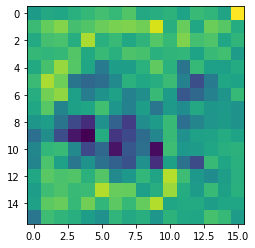

Level in downsampling hierarchy: 2
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


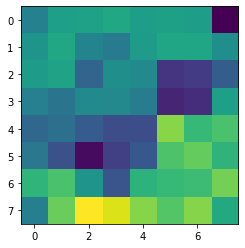

Level in downsampling hierarchy: 3
Shape of difference between conditional and unconditional preds: torch.Size([1280, 8, 8])
Shape of mean of difference: torch.Size([8, 8])


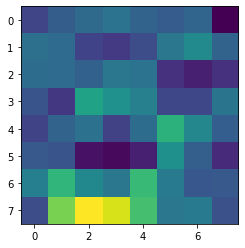

In [23]:
for li in sample_list_list:
    show_sample_reps(li)